
Reuse the FN433596 bam file.
Need to name the reference.fasta to ENA|FN433596|FN433596.1.fa


https://github.com/abyzovlab/CNVnator/wiki/Calling-CNVs

```
cnvnator -root out.root -tree FN433596.fasta.sorted.bam 

# GENERATING HISTOGRAM
cnvnator -root out.root -his 100 

#CALCULATING STATISTICS 
cnvnator -root out.root -stat 100

#RD SIGNAL PARTITIONING
cnvnator -root out.root -partition 100 -ngc

# CNV calling
cnvnator -root out.root -call 100 -ngc > events_bin100.txt

```

Took 40 seconds 

Setting the binning to 1, the all analysis takes about 10 minutes.
```
cnvnator -root out.root -tree FN433596.fasta.sorted.bam 
cnvnator -root out.root -his 1
cnvnator -root out.root -stat 1
cnvnator -root out.root -partition 1 -ngc
cnvnator -root out.root -call 1 -ngc > events_bin1.txt
```

Took 24 minutes

Finally, we also run CNVnator with a bin of 6. According to the paper, optimal bin size, and thus breakpoint resolution accuracy scales roughtly inversely with the coverage. 100 for coverage of 20-30X, 30 for coverage og 100X, so we extrapolate to a bin of 6 for 500X. The analysis took about 5 minutes.

- sequana coverage W=20000 takes 2 minutes with reports and conversion BAM to BED and about 1 minute if BED is already preseent.

In [1]:
from sequana import GenomeCov
%pylab inline
rcParams['figure.figsize'] = (10,7)
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [10]:
from sequana.cnv import CNVnator
df1 = CNVnator("events_bin1.txt").df
df6 = CNVnator("events_bin6.txt").df
df100 = CNVnator("events_bin100.txt").df

In [11]:
len(df1), len(df6), len(df100)

(207, 72, 13)

In [12]:
# load the BED and genbank file
b = GenomeCov("FN433596.bed")
chromosome = b.chr_list[0]
chromosome.run(100001, circular=True, cnv_delta=10)
chromosome.rois.df.to_csv("rois_100000_10.csv")    
    
def plot_variant(chrom, x1=526000, x2=538000):
    clf()    
    chrom.plot_rois(x1, x2)
    roi = chrom.rois
    low = roi.get_low_rois()
    high = roi.get_high_rois()
    chr = chrom
    highT = (chr.thresholds.high * chr.best_gaussian["sigma"] +
         chr.best_gaussian["mu"]) * chr.df["rm"]
    lowT = (chr.thresholds.low * chr.best_gaussian["sigma"] +
        chr.best_gaussian["mu"]) * chr.df["rm"]

    if len(low):
        for k,v in low.iterrows():        
            Y1 = chr.df['cov'].loc[v.start:v.end]
            Y2 = lowT.loc[v.start:v.end] 
            Y1 = Y1.combine(Y2, max) *0
            if v.start > x1 and v.end<x2:
                try:fill_between(range(v.start, v.end+1), Y1, Y2, alpha=0.6, color="blue")
                except:pass
    
    if len(high):
        for k,v in high.iterrows():
            Y1 = highT.loc[v.start:v.end]
            Y2 = chr.df['cov'].loc[v.start:v.end]
            Y2 = Y2.combine(Y1,max)
            if v.start > x1 and v.end<x2:
                try:fill_between(range(v.start, v.end+1), y1=Y1,y2=Y2 ,alpha=0.6, color="orange")
                except:pass

    xlim([x1,x2])

    return chromosome

In [13]:
from easydev import Progress
cnvnator = df6
N = len(cnvnator)
pb = Progress(N)
for i in range(N):
    this = cnvnator.loc[i]
    try:
        # develop branhc
        chro = plot_variant(chromosome, max(this.start-10000, 0), 
                    this.end+10000, color_low="b")
    except:
        chro = plot_variant(chromosome, max(this.start-10000, 0), 
                    this.end+10000)
        
    x1, x2 = xlim()
    L = x2-x1
    color = "yellow"
    # this[3] currently holds the ratio between CNV and mean
    axhline(chro.df['cov'].mean() * this[3], (this.start-x1)/L, 
            (this.end-x1)/L, lw=8, color=color, alpha=0.5)
    savefig("comp_cnv_bin6_{}.png".format(i+1), dpi=200)
    pb.animate(i+1)
close()               


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# conclusion

- Using a bin of 100, the 13 events detected by CNVnator are also detected with sequana_coverage
- Using a bin of 6, the 72 events detected by CNVnator are also detected with sequana_coverage
- Using a bin of 1, amongst the 200 events many false positives are reported either short (few bases) or long (kb).

- sequana_coverage detects additional events (see images below for a few examples) 
  - very short (See e.G. image comp_cnv_2.png, position 380000)
  - medium size (see e.g. image comp_cnv_2.png, position 395000)
  - very short and strong events (e.g. comp_cnv_3, position 540000)
  - long (e.g. comp_cnv_12.png, position 2444242, event of 2163 bases)
- CNVnator is better at detected long events. For instance, in comp_cnv_10.png, the large gap is detected. Here with sequana_coverage we also detect it but if the window paramter were too short, we could have missed it. 

In [6]:
from IPython.display import Image, HTML

Event detected in CNVnator (red thick line) and sequana_coverage (green line). Note that there are other events detected with sequana_coverage: short (red and green dots), medium size event also at position 395000

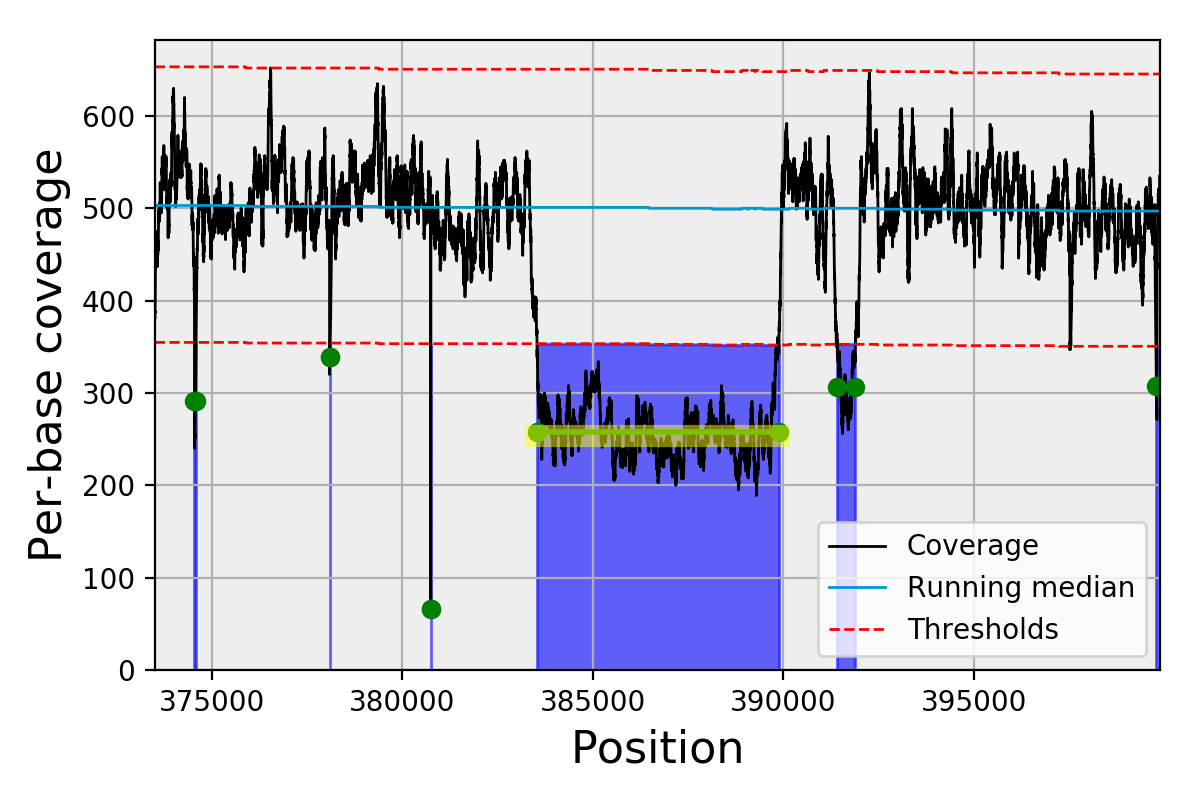

In [7]:
Image("comp_cnv_2.png")

Strong and short events (right hand side) are detected by sequana_coverage (here as a single events because we clustered events with distances below 1000 bases)

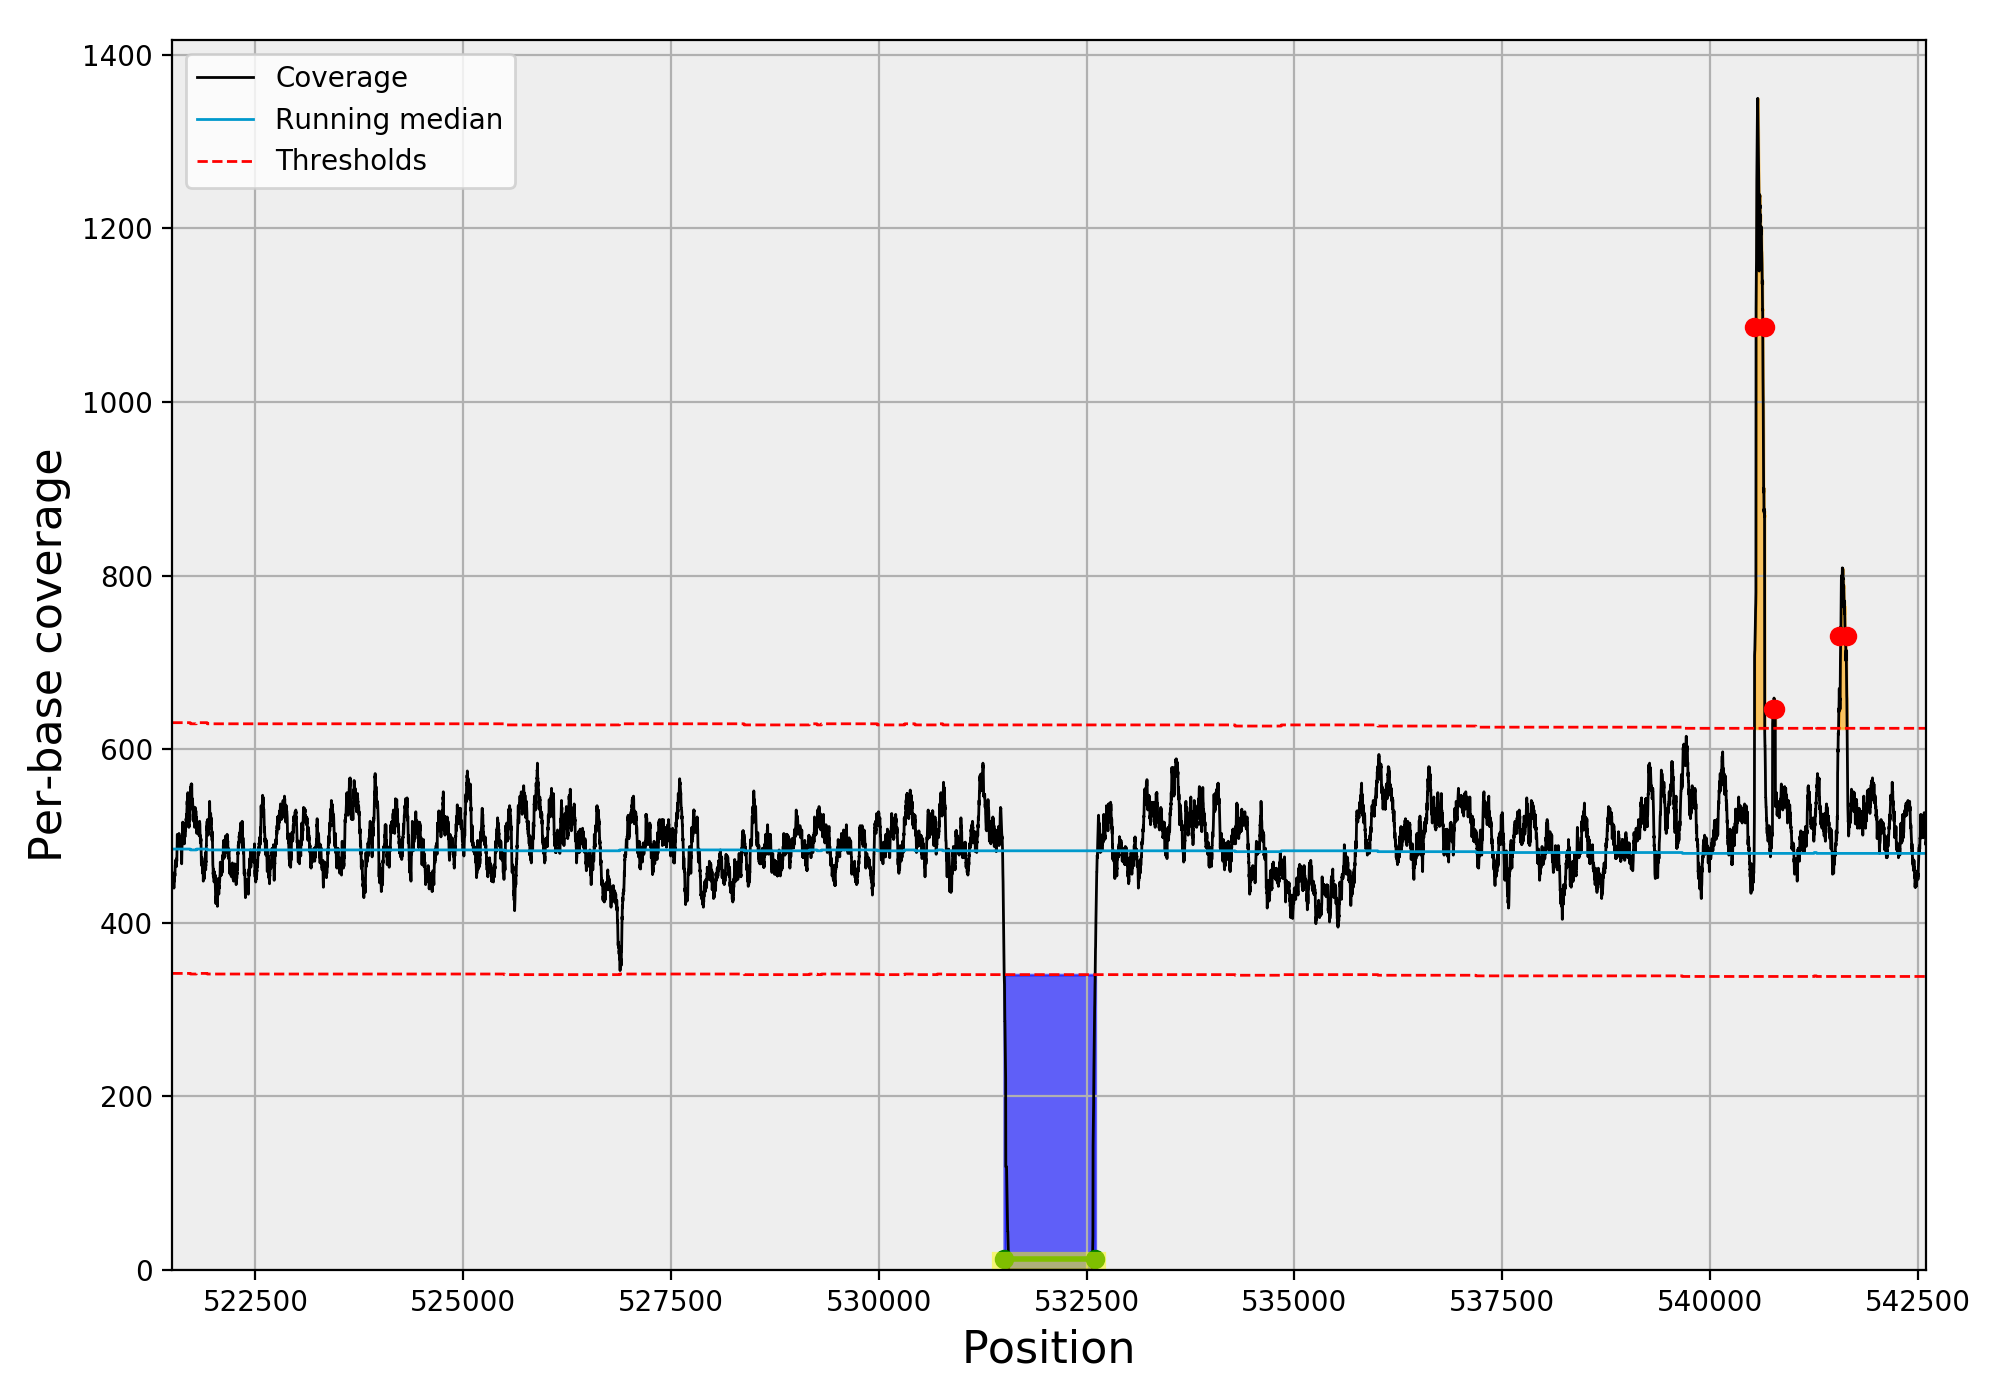

In [51]:
Image("comp_cnv_3.png")

Complex pattern such as the following ones are handled correctly in sequana_coverage: we detect 4 distincts long events.
CNVnator itself, find the first and last events only;

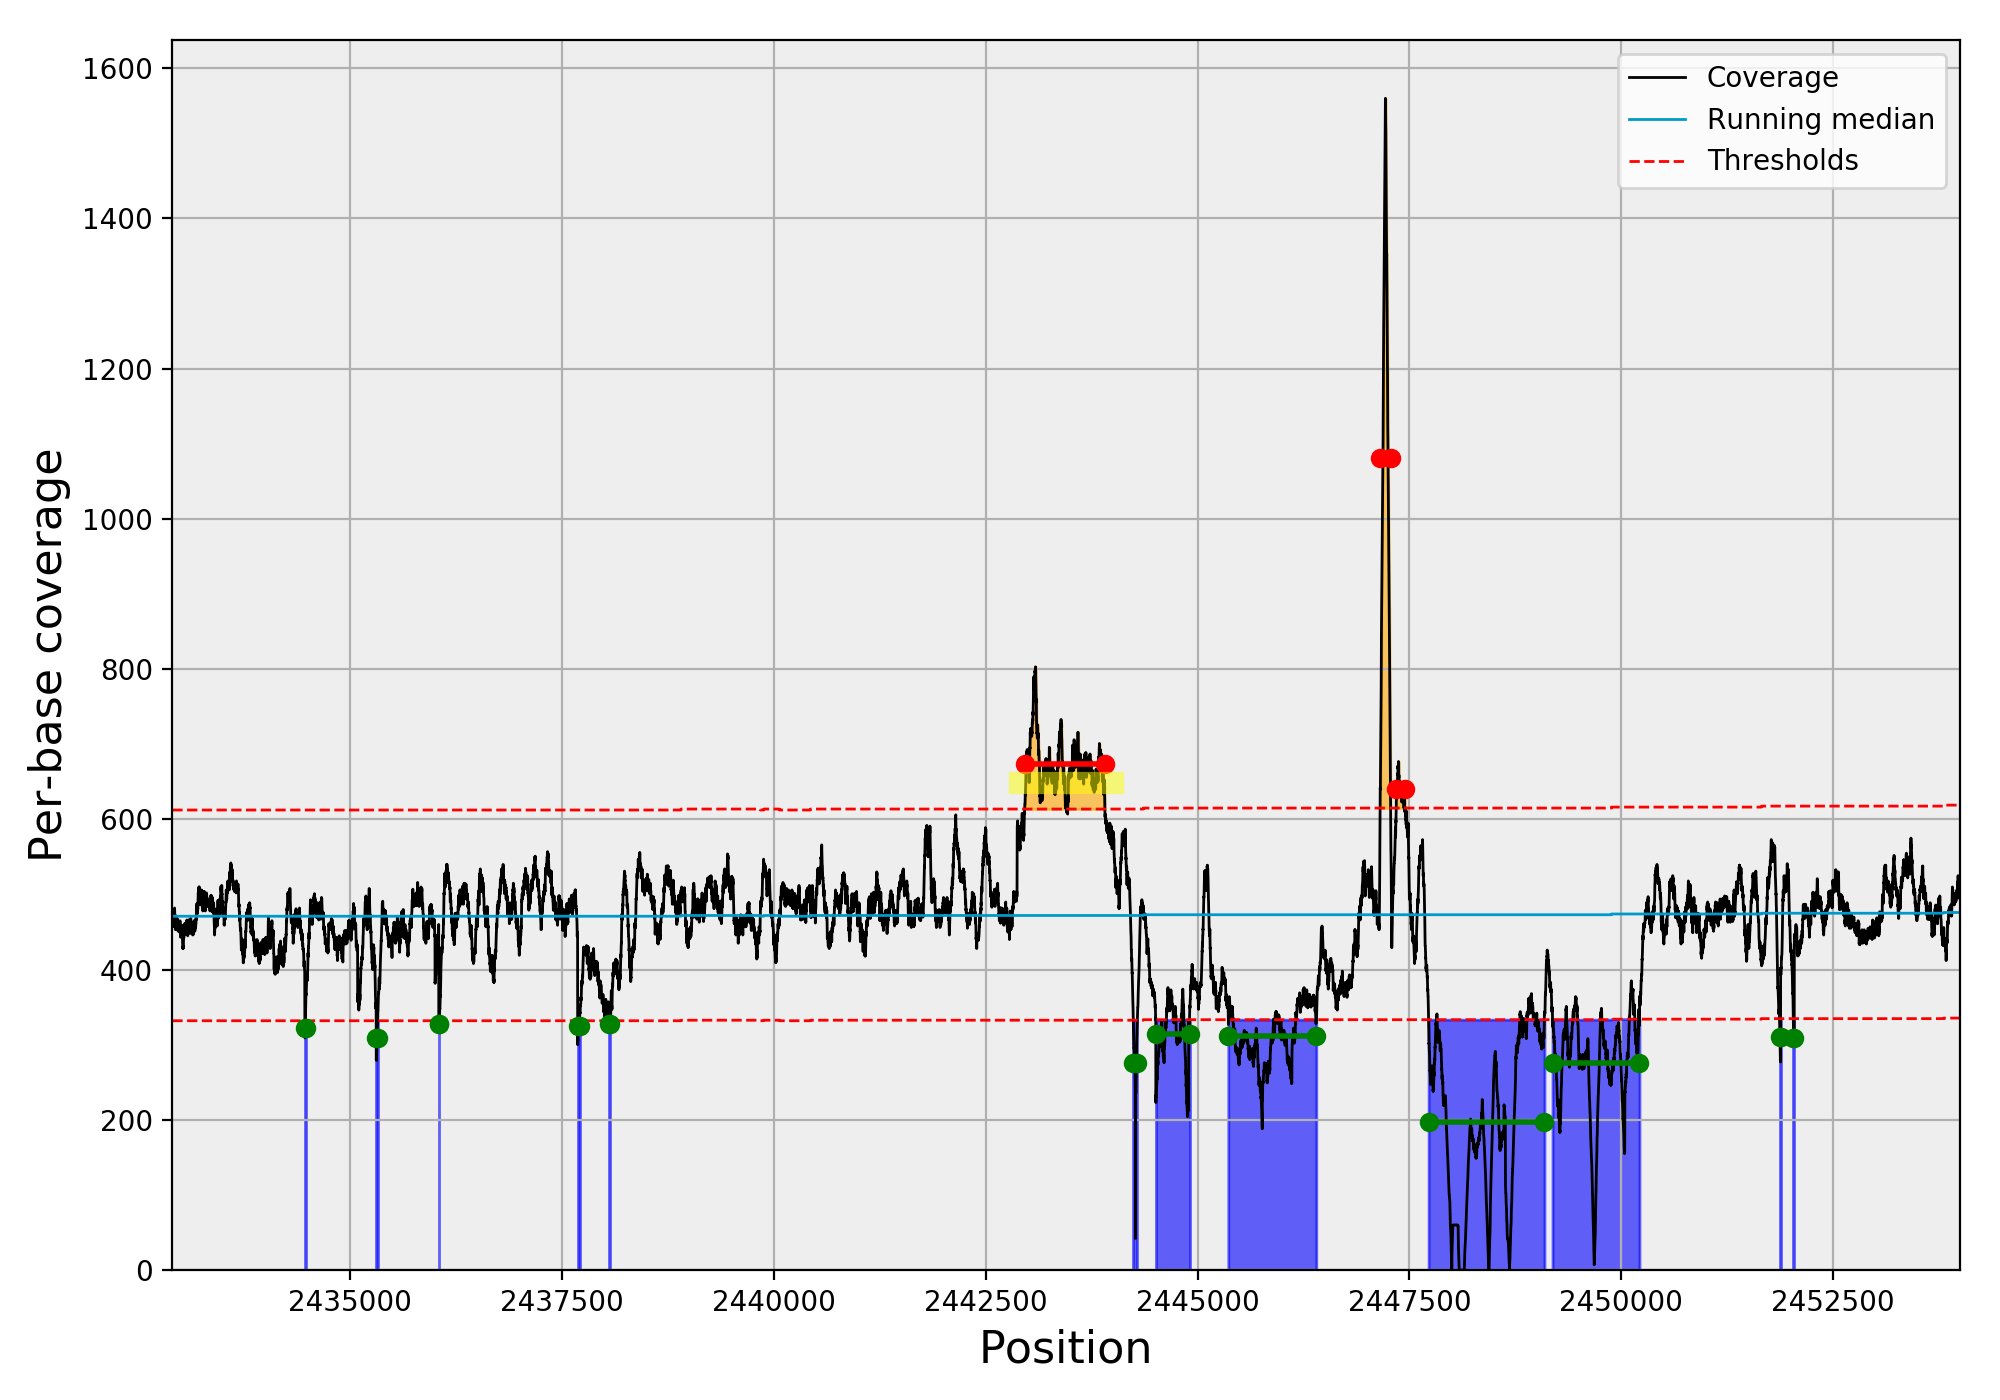

In [53]:
Image("comp_cnv_12.png")


Event that could have been missed by sequana_coverage if $W$ were shorter. Although, special case of deleted regions
are systematically reported. 

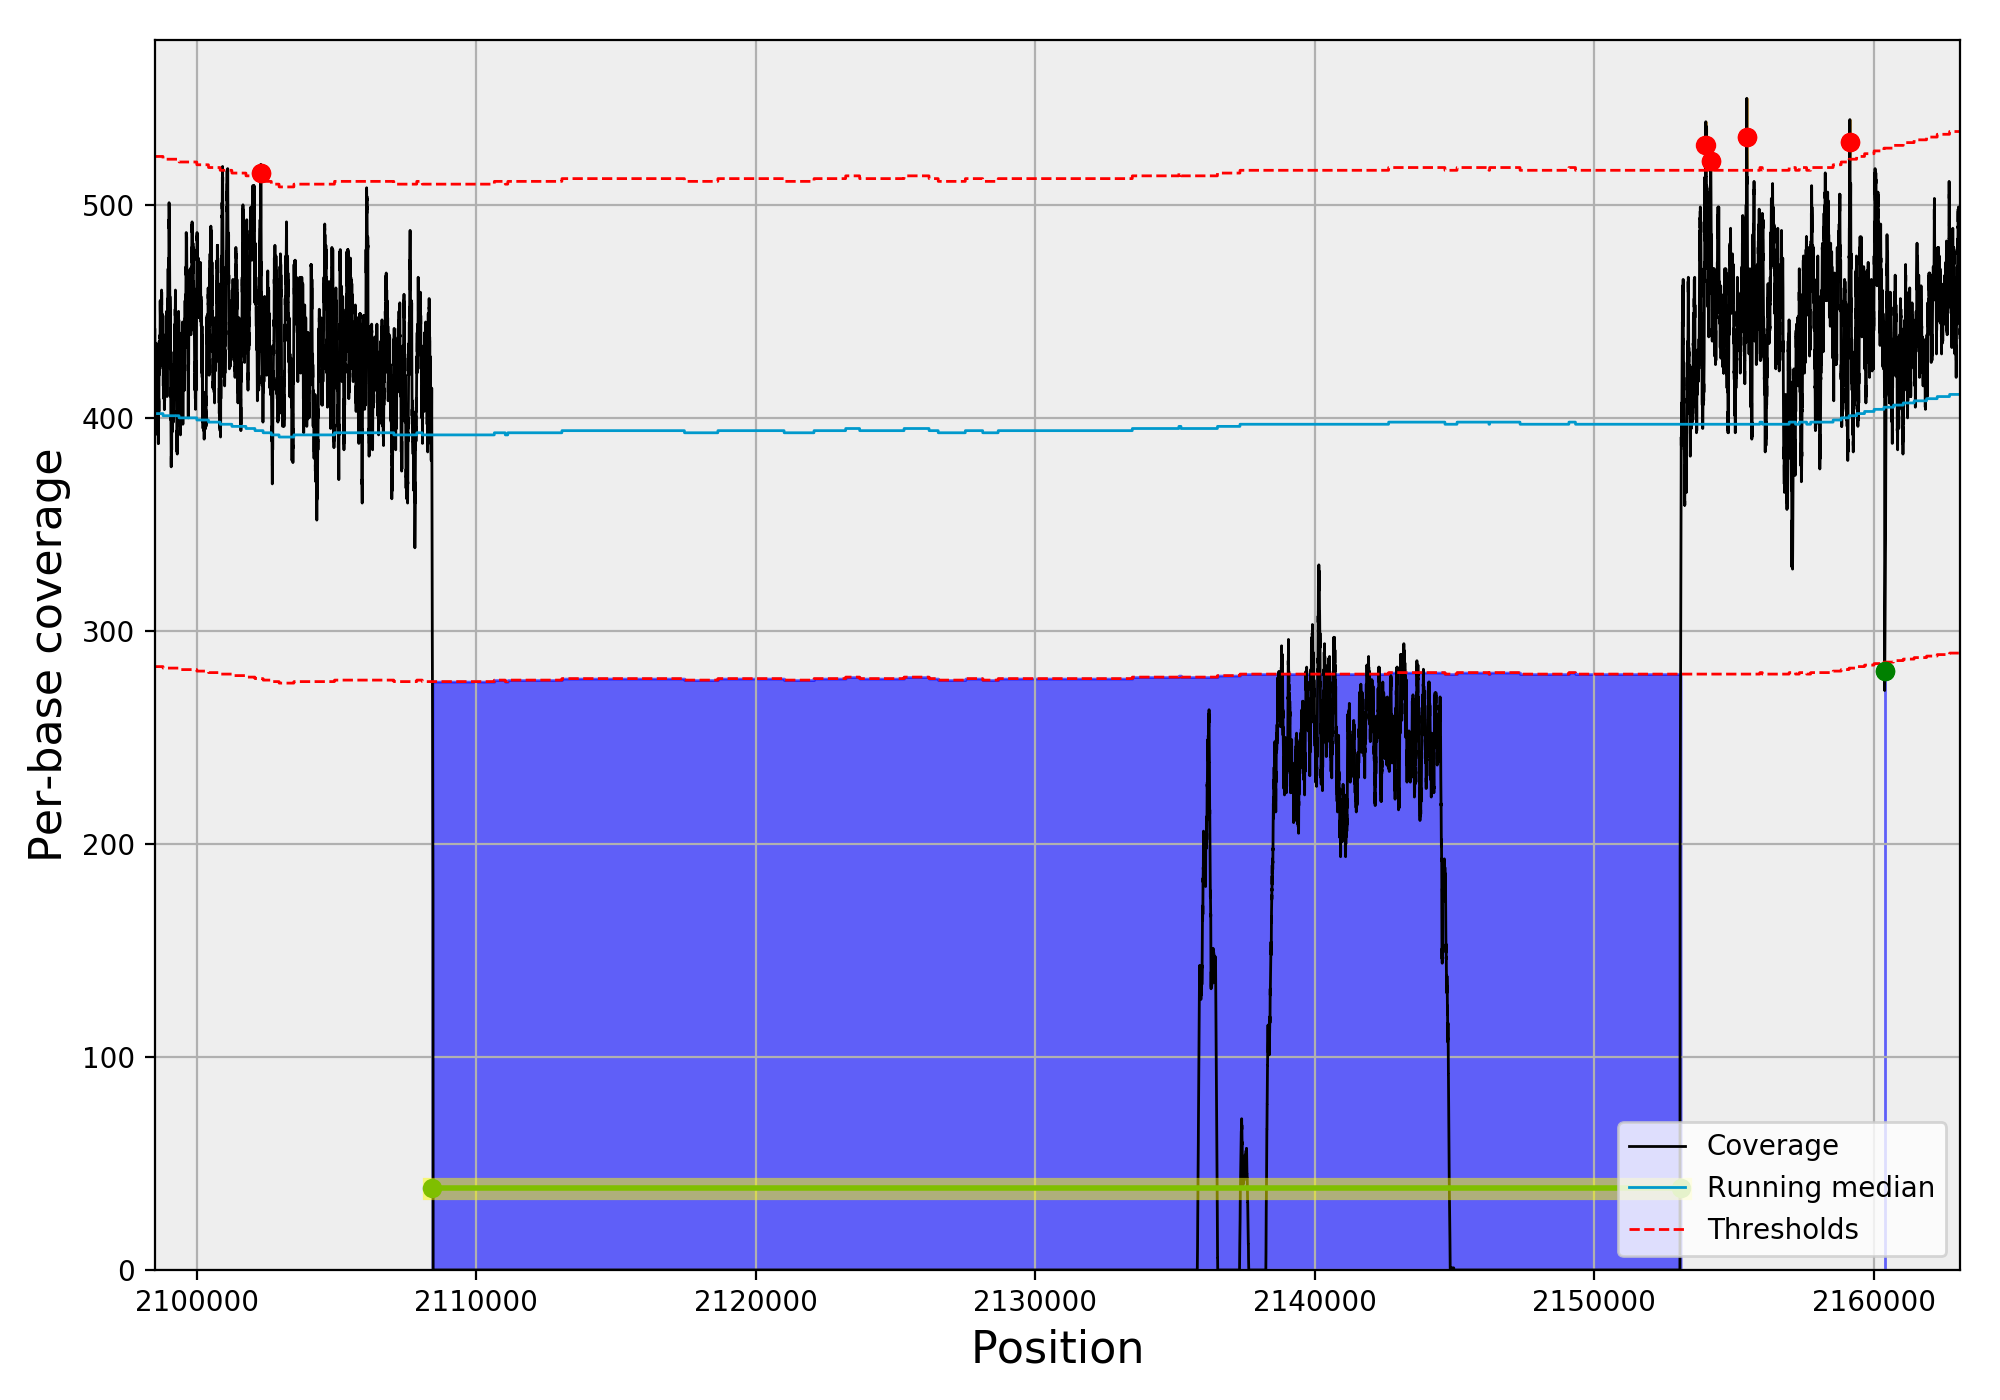

In [54]:
Image("comp_cnv_10.png")


# Example of galse positives found by CNVnator with bin=1

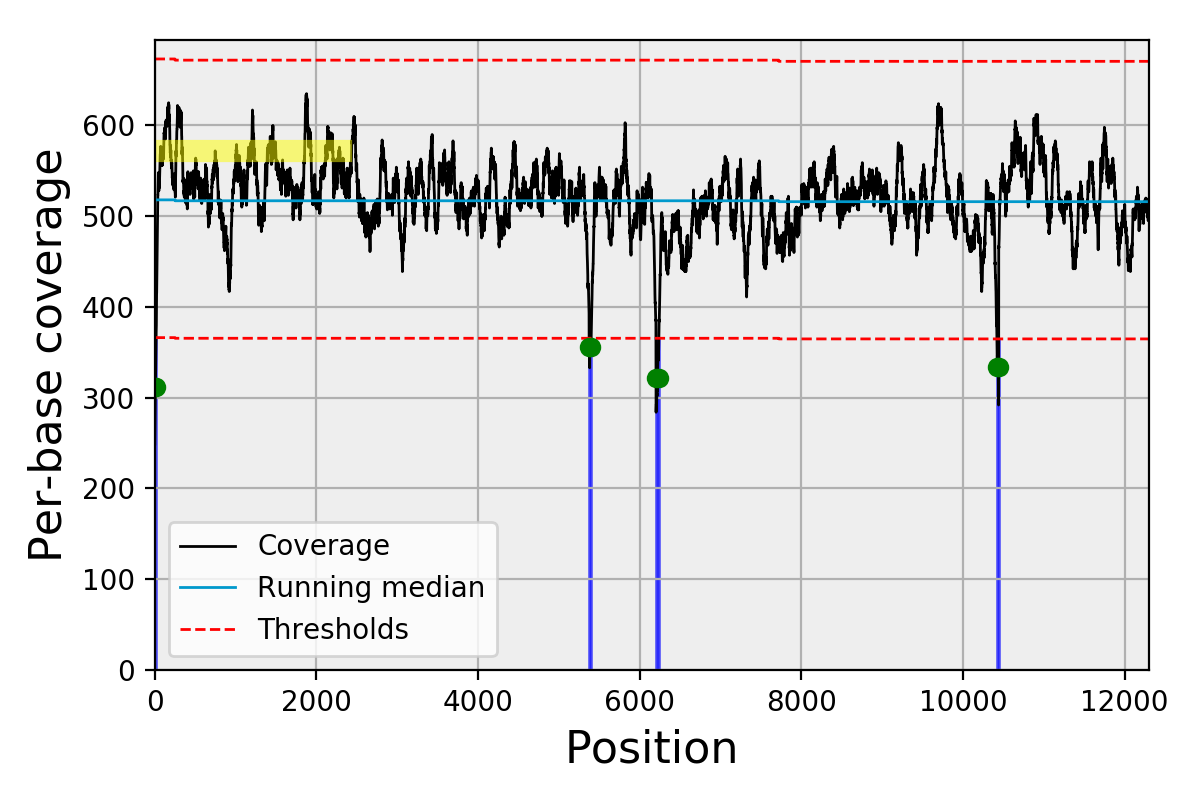

In [14]:
Image("comp_cnv_bin1_1.png")

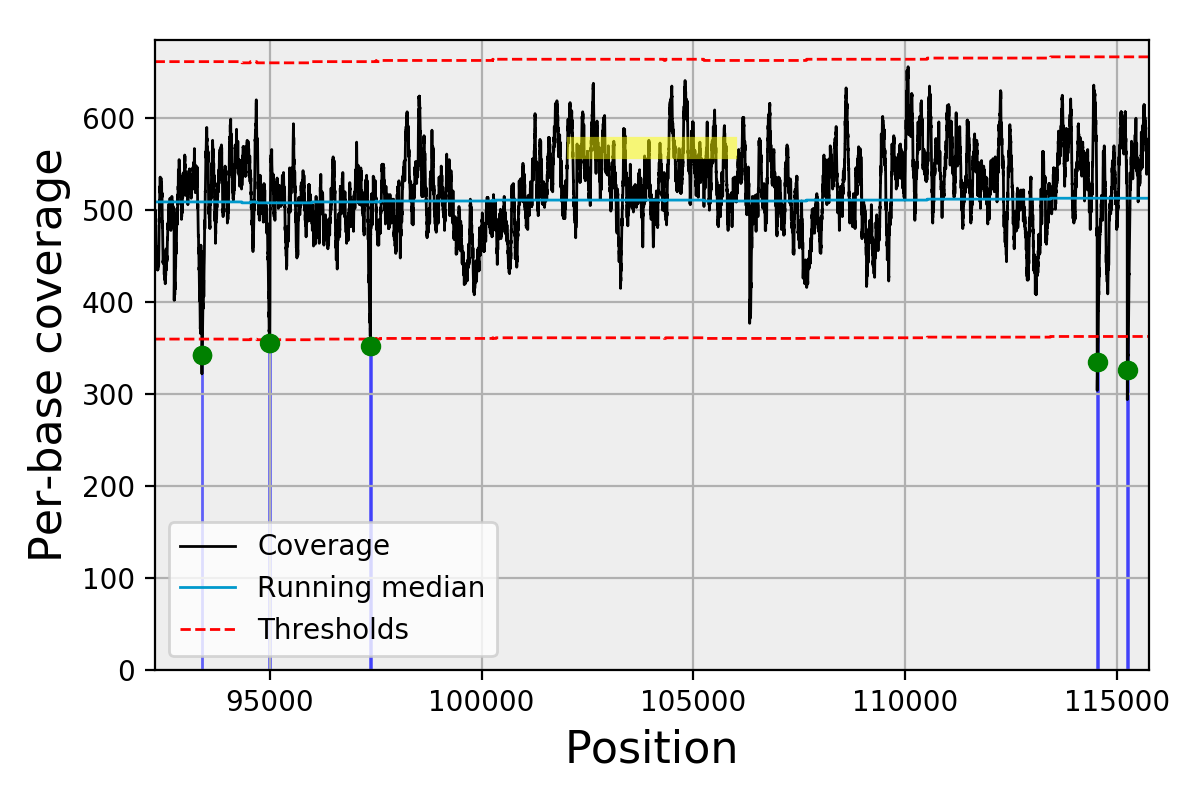

In [16]:
Image("comp_cnv_bin1_17.png")

See other files calld `comp_cnv_bin1_*.png` in this directory